# How consistently are areas ranked?

For each month, compute the ranking of each area in terms of ASB incidents (with smoothing) and measure temporal consistency (somehow)


In [236]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [237]:
from collections import defaultdict
from itertools import pairwise

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from spatial import SpatialUnit, get_force_boundary, map_to_spatial_unit
from utils import (
    CATEGORIES,
    calc_gini,
    cosine_similarity,
    extract_crime_data,
    lorenz_curve,
    rank_biased_overlap,
    rank_biased_overlap_weight,
    spearman_rank_correlation,
    spearman_rank_correlation_matrix,
    tokenize_force_name,
)


## Set parameters and fetch crime data

Spatial unit comparison (census geographies control for resident population and can vary widely in area)

Unit | Size/resolution | Mean area (km²)*
-----|-----------------|----------
MSOA |                 | 6.7
HEX  | 7               | 4.6
LSOA |                 | 1.4
GRID | 1000m           | 1.0
HEX  | 8               | 0.65
OA   |                 | 0.28
GRID | 500m            | 0.25
GRID | 200m            | 0.04
HEX  | 9               | 0.093

&ast; over West Yorkshire force area

In [207]:
FORCE = "West Yorkshire"
CATEGORY = CATEGORIES[1]  # ASB
OBSERVATION_WINDOW = 3  # months
AREA: SpatialUnit = "STREET"
AREA_PARAMETERS = defaultdict(
    dict,
    {
        "LSOA": {"resolution": "FE"},
        "GRID": {"size": 500.0},
        "HEX": {"resolution": 8},
    },
)
SAMPLE_FRACTION = 0.5

In [208]:
force_boundary = get_force_boundary(FORCE)
raw_crime_data = extract_crime_data(tokenize_force_name(FORCE))
# filter by category and remove any points
raw_crime_data = raw_crime_data[raw_crime_data["Crime type"] == CATEGORY]
raw_crime_data = raw_crime_data[raw_crime_data.geometry.intersects(force_boundary.geometry.union_all())]
timespan = len(raw_crime_data.Month.unique()) / 12
raw_crime_data

Month            Reported by           Falls within  \
Crime ID                                                          
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
...           ...                    ...                    ...   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   

                              Location  LSOA code       LSOA name  \
Crime ID                                                            
NaN         On or near Queen'S Gardens  E01010692   Bradford 001D   
NaN       On or near Bus/Coach Station  E01010692   Bradford 001D   
NaN              On or near Wells Road  E01010692   Bradford 001D   
NaN       On or near Bus/Coach Station  E01010692   Bradford 001D   
NaN            On or near Springs Lane  E01010691   Bradford 002A   
...                                ...        ...             ...   
NaN             On or near John Street  E01011863  Wakefield 044D   
NaN            On or near Beech Street  E01011863  Wakefield 044D   
NaN         On or near Princess Avenue  E01011863  Wakefield 044D   
NaN                On or near Beamshaw  E01011866  Wakefield 045B   
NaN         On or near Park/Open Space  E01011868  Wakefield 045C   

                     Crime type                       geometry  
Crime ID                                                        
NaN       Anti-social behaviour  POINT (411354.013 447133.948)  
NaN       Anti-social behaviour  POINT (411854.969 447613.948)  
NaN       Anti-social behaviour   POINT (411758.03 447302.948)  
NaN       Anti-social behaviour  POINT (411854.969 447613.948)  
NaN       Anti-social behaviour  POINT (412391.978 447481.039)  
...                         ...                            ...  
NaN       Anti-social behaviour  POINT (446750.007 410878.044)  
NaN       Anti-social behaviour  POINT (446414.024 410431.008)  
NaN       Anti-social behaviour  POINT (446666.975 410800.005)  
NaN       Anti-social behaviour   POINT (444840.023 410291.97)  
NaN       Anti-social behaviour  POINT (444982.991 411990.995)  

[81698 rows x 8 columns]

## Get spatial data

Assign crimes to spatial units requested for later aggregation

In [209]:
crime_data, spatial_units = map_to_spatial_unit(raw_crime_data, force_boundary, AREA, **AREA_PARAMETERS[AREA])
crime_data

Month            Reported by           Falls within  \
Crime ID                                                          
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
...           ...                    ...                    ...   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   

                              Location  LSOA code       LSOA name  \
Crime ID                                                            
NaN         On or near Queen'S Gardens  E01010692   Bradford 001D   
NaN       On or near Bus/Coach Station  E01010692   Bradford 001D   
NaN              On or near Wells Road  E01010692   Bradford 001D   
NaN       On or near Bus/Coach Station  E01010692   Bradford 001D   
NaN            On or near Springs Lane  E01010691   Bradford 002A   
...                                ...        ...             ...   
NaN             On or near John Street  E01011863  Wakefield 044D   
NaN            On or near Beech Street  E01011863  Wakefield 044D   
NaN         On or near Princess Avenue  E01011863  Wakefield 044D   
NaN                On or near Beamshaw  E01011866  Wakefield 045B   
NaN         On or near Park/Open Space  E01011868  Wakefield 045C   

                     Crime type                       geometry  \
Crime ID                                                         
NaN       Anti-social behaviour  POINT (411354.013 447133.948)   
NaN       Anti-social behaviour  POINT (411854.969 447613.948)   
NaN       Anti-social behaviour   POINT (411758.03 447302.948)   
NaN       Anti-social behaviour  POINT (411854.969 447613.948)   
NaN       Anti-social behaviour  POINT (412391.978 447481.039)   
...                         ...                            ...   
NaN       Anti-social behaviour  POINT (446750.007 410878.044)   
NaN       Anti-social behaviour  POINT (446414.024 410431.008)   
NaN       Anti-social behaviour  POINT (446666.975 410800.005)   
NaN       Anti-social behaviour   POINT (444840.023 410291.97)   
NaN       Anti-social behaviour  POINT (444982.991 411990.995)   

                          spatial_unit    distance  
Crime ID                                            
NaN       (12843840683, 1336722281, 0)    0.981018  
NaN            (28141941, 28141947, 0)   19.483412  
NaN            (24556540, 24556624, 0)    1.545469  
NaN            (28141941, 28141947, 0)   19.483412  
NaN           (20940863, 676654317, 0)    0.843365  
...                                ...         ...  
NaN          (853543211, 853543210, 0)    0.513230  
NaN        (662951565, 11227573808, 0)    1.741161  
NaN          (853543232, 853543210, 0)    1.622820  
NaN          (861301782, 861302217, 0)    0.308565  
NaN       (6455532392, 12752999665, 0)  147.824679  

[81698 rows x 10 columns]

In [210]:
# optionally explore discrepancies between reported point and reported LSOA
if AREA == "LSOA":
    mismatches = crime_data[crime_data["spatial_unit"] != crime_data["LSOA code"]][
        ["spatial_unit", "LSOA21NM", "LSOA code", "LSOA name", "geometry"]
    ]  # should be true if LSOA code is set correctly
    mismatches["reported_geometry"] = mismatches["LSOA code"].map(spatial_units.geometry)
    distances = mismatches.geometry.distance(mismatches.reported_geometry)
    display(
        f"Total mismatches {len(mismatches)} of which {mismatches.reported_geometry.isna().sum()} are inactive LSOAs"
    )
    display(f"Point-reported geometry discrepancy distance mean={distances.mean():.1f}m max={distances.max():.1f}m")

## Compute counts and rates

Display rates for each area on a map (too many street segments to render)

In [211]:
# ensure we account for crime-free spatial units in the data
counts = (
    crime_data.groupby(["Month", "spatial_unit"])["Crime type"]
    .count()
    .unstack(level="Month", fill_value=0)
    .sort_index()
)
# num_areas = len(crime_data.area.unique())
smoothed_counts = counts.T.rolling(OBSERVATION_WINDOW).mean().dropna().T
smoothed_counts

Month                           2022-07   2022-08   2022-09   2022-10  \
spatial_unit                                                            
(318837, 270591425, 0)         0.000000  1.000000  1.000000  1.000000   
(321632, 321645, 0)            0.000000  0.000000  0.000000  0.000000   
(321692, 344764167, 0)         0.333333  0.333333  0.000000  0.000000   
(321759, 614241872, 0)         0.333333  0.333333  0.333333  0.666667   
(321854, 247782201, 0)         1.333333  2.666667  2.666667  1.666667   
...                                 ...       ...       ...       ...   
(12840668914, 263708202, 0)    0.333333  0.333333  0.333333  0.666667   
(12840668980, 12467726967, 0)  0.333333  0.666667  0.666667  0.666667   
(12843840683, 1336722281, 0)   0.333333  0.000000  0.000000  0.000000   
(12848422868, 27415046, 0)     0.000000  0.000000  0.000000  0.000000   
(12889120735, 983507402, 0)    0.333333  0.333333  0.000000  0.000000   

Month                           2022-11   2022-12   2023-01   2023-02  \
spatial_unit                                                            
(318837, 270591425, 0)         0.000000  0.000000  0.000000  0.000000   
(321632, 321645, 0)            0.000000  0.000000  0.000000  0.000000   
(321692, 344764167, 0)         0.000000  0.000000  0.000000  0.000000   
(321759, 614241872, 0)         0.666667  0.666667  0.333333  1.333333   
(321854, 247782201, 0)         0.333333  0.666667  1.000000  1.000000   
...                                 ...       ...       ...       ...   
(12840668914, 263708202, 0)    0.333333  0.333333  0.000000  0.000000   
(12840668980, 12467726967, 0)  0.333333  0.333333  0.000000  0.333333   
(12843840683, 1336722281, 0)   0.000000  0.000000  0.000000  0.000000   
(12848422868, 27415046, 0)     0.000000  0.000000  0.000000  0.000000   
(12889120735, 983507402, 0)    0.000000  0.000000  0.000000  0.000000   

Month                           2023-03   2023-04  ...   2024-07   2024-08  \
spatial_unit                                       ...                       
(318837, 270591425, 0)         0.000000  0.000000  ...  0.000000  0.000000   
(321632, 321645, 0)            0.000000  0.000000  ...  0.000000  0.000000   
(321692, 344764167, 0)         0.000000  0.000000  ...  0.000000  0.000000   
(321759, 614241872, 0)         1.333333  1.000000  ...  0.333333  0.333333   
(321854, 247782201, 0)         1.333333  0.666667  ...  0.666667  1.000000   
...                                 ...       ...  ...       ...       ...   
(12840668914, 263708202, 0)    0.000000  0.333333  ...  0.333333  0.333333   
(12840668980, 12467726967, 0)  0.333333  0.333333  ...  0.000000  0.000000   
(12843840683, 1336722281, 0)   0.000000  0.000000  ...  0.000000  0.000000   
(12848422868, 27415046, 0)     0.000000  0.000000  ...  0.333333  0.000000   
(12889120735, 983507402, 0)    0.000000  0.000000  ...  0.000000  0.000000   

Month                           2024-09   2024-10   2024-11   2024-12  \
spatial_unit                                                            
(318837, 270591425, 0)         0.000000  0.666667  0.666667  1.000000   
(321632, 321645, 0)            0.000000  0.000000  0.333333  0.333333   
(321692, 344764167, 0)         0.000000  0.000000  0.000000  0.000000   
(321759, 614241872, 0)         0.000000  0.000000  0.333333  0.333333   
(321854, 247782201, 0)         0.666667  0.333333  0.000000  0.000000   
...                                 ...       ...       ...       ...   
(12840668914, 263708202, 0)    0.333333  0.000000  0.333333  0.666667   
(12840668980, 12467726967, 0)  0.000000  0.000000  0.000000  0.000000   
(12843840683, 1336722281, 0)   0.000000  0.000000  0.000000  0.000000   
(12848422868, 27415046, 0)     0.000000  0.000000  0.000000  0.333333   
(12889120735, 983507402, 0)    0.000000  0.000000  0.000000  0.000000   

Month                           2025-01   2025-02   2025-03  2025-04  
spatial_unit                                                    

In [212]:
# compute rates
if AREA == "STREET":
    # proxy area as length * a width factor thats consistent with the force area
    width_factor = force_boundary.area.sum() / spatial_units.length.sum()
    areas = counts.index.map(spatial_units.length) * width_factor
else:
    areas = counts.index.map(spatial_units.area)

rates = counts.div(areas, axis=0) / timespan * 1_000_000  # crimes/sq.km/year
smoothed_rates = rates.T.rolling(OBSERVATION_WINDOW).mean().dropna().T
smoothed_rates

Month                            2022-07    2022-08    2022-09    2022-10  \
spatial_unit                                                                
(318837, 270591425, 0)          0.000000   0.998879   0.998879   0.998879   
(321632, 321645, 0)             0.000000   0.000000   0.000000   0.000000   
(321692, 344764167, 0)          1.051665   1.051665   0.000000   0.000000   
(321759, 614241872, 0)          0.255623   0.255623   0.255623   0.511246   
(321854, 247782201, 0)          9.502658  19.005317  19.005317  11.878323   
...                                  ...        ...        ...        ...   
(12840668914, 263708202, 0)    19.073998  19.073998  19.073998  38.147995   
(12840668980, 12467726967, 0)  28.359036  56.718071  56.718071  56.718071   
(12843840683, 1336722281, 0)   30.633299   0.000000   0.000000   0.000000   
(12848422868, 27415046, 0)      0.000000   0.000000   0.000000   0.000000   
(12889120735, 983507402, 0)     5.989830   5.989830   0.000000   0.000000   

Month                            2022-11    2022-12   2023-01    2023-02  \
spatial_unit                                                               
(318837, 270591425, 0)          0.000000   0.000000  0.000000   0.000000   
(321632, 321645, 0)             0.000000   0.000000  0.000000   0.000000   
(321692, 344764167, 0)          0.000000   0.000000  0.000000   0.000000   
(321759, 614241872, 0)          0.511246   0.511246  0.255623   1.022492   
(321854, 247782201, 0)          2.375665   4.751329  7.126994   7.126994   
...                                  ...        ...       ...        ...   
(12840668914, 263708202, 0)    19.073998  19.073998  0.000000   0.000000   
(12840668980, 12467726967, 0)  28.359036  28.359036  0.000000  28.359036   
(12843840683, 1336722281, 0)    0.000000   0.000000  0.000000   0.000000   
(12848422868, 27415046, 0)      0.000000   0.000000  0.000000   0.000000   
(12889120735, 983507402, 0)     0.000000   0.000000  0.000000   0.000000   

Month                            2023-03    2023-04  ...    2024-07  \
spatial_unit                                         ...              
(318837, 270591425, 0)          0.000000   0.000000  ...   0.000000   
(321632, 321645, 0)             0.000000   0.000000  ...   0.000000   
(321692, 344764167, 0)          0.000000   0.000000  ...   0.000000   
(321759, 614241872, 0)          1.022492   0.766869  ...   0.255623   
(321854, 247782201, 0)          9.502658   4.751329  ...   4.751329   
...                                  ...        ...  ...        ...   
(12840668914, 263708202, 0)     0.000000  19.073998  ...  19.073998   
(12840668980, 12467726967, 0)  28.359036  28.359036  ...   0.000000   
(12843840683, 1336722281, 0)    0.000000   0.000000  ...   0.000000   
(12848422868, 27415046, 0)      0.000000   0.000000  ...   3.384591   
(12889120735, 983507402, 0)     0.000000   0.000000  ...   0.000000   

Month                            2024-08    2024-09   2024-10    2024-11  \
spatial_unit                                                               
(318837, 270591425, 0)          0.000000   0.000000  0.665919   0.665919   
(321632, 321645, 0)             0.000000   0.000000  0.000000   0.802843   
(321692, 344764167, 0)          0.000000   0.000000  0.000000   0.000000   
(321759, 614241872, 0)          0.255623   0.000000  0.000000   0.255623   
(321854, 247782201, 0)          7.126994   4.751329  2.375665   0.000000   
...                                  ...        ...       ...        ...   
(12840668914, 263708202, 0)    19.073998  19.073998  0.000000  19.073998   
(12840668980, 12467726967, 0)   0.000000   0.000000  0.000000   0.000000   
(12843840683, 1336722281, 0)    0.000000   0.000000  0.000000   0.000000   
(12848422868, 27415046, 0)      0.000000   0.000000  0.000000   0.000000   
(12889120735, 983507402, 0)     0.000000   0.000000  0.000000   0.000000   

Month                            2024-12    2025-01    2025-02    2025-03  \
spatial_unit       

In [213]:
if AREA == "STREET":
    map = None
else:
    map = (
        spatial_units.join(rates.sum(axis=1).rename("rate"))
        .fillna(0)
        .explore(
            "rate",
            cmap="Reds",
            tiles="CartoDB positron",
            style_kwds=dict(color="black", weight=0.5, opacity=0.2, fillOpacity=0.7),
        )
    )
# force_boundary.explore(m=map, style_kwds=dict(color="black", weight=0.5, opacity=0.2, fillOpacity=0.0))
map

Month     2022-05   2022-06   2022-07   2022-08   2022-09   2022-10   2022-11  \
Month                                                                           
2022-05  1.000000  0.996599  0.992917  0.992224  0.997425  0.997310  0.996793   
2022-06  0.996599  1.000000  0.994715  0.994273  0.996106  0.996223  0.993292   
2022-07  0.992917  0.994715  1.000000  0.995539  0.993675  0.994070  0.988493   
2022-08  0.992224  0.994273  0.995539  1.000000  0.993154  0.993566  0.987568   
2022-09  0.997425  0.996106  0.993675  0.993154  1.000000  0.997731  0.996816   
2022-10  0.997310  0.996223  0.994070  0.993566  0.997731  1.000000  0.996477   
2022-11  0.996793  0.993292  0.988493  0.987568  0.996816  0.996477  1.000000   
2022-12  0.989736  0.982917  0.974731  0.973262  0.989379  0.988471  0.995764   
2023-01  0.993901  0.988634  0.982015  0.980817  0.993701  0.993049  0.998080   
2023-02  0.995878  0.991674  0.986247  0.985171  0.995829  0.995371  0.998747   
2023-03  0.997287  0.994428  0.990370  0.989527  0.997426  0.997141  0.998495   
2023-04  0.997121  0.996310  0.994317  0.993942  0.997627  0.997537  0.995977   
2023-05  0.994285  0.995401  0.995638  0.995482  0.994909  0.995238  0.990679   
2023-06  0.996283  0.996253  0.995138  0.994713  0.996774  0.996933  0.994183   
2023-07  0.997092  0.996278  0.994378  0.993907  0.997465  0.997488  0.995862   
2023-08  0.996648  0.996348  0.994921  0.994496  0.997125  0.997165  0.994819   
2023-09  0.997221  0.996235  0.994144  0.993657  0.997603  0.997618  0.996193   
2023-10  0.996705  0.996312  0.994790  0.994384  0.997146  0.997254  0.995058   
2023-11  0.996970  0.993662  0.989122  0.988200  0.996971  0.996637  0.998725   
2023-12  0.991321  0.985015  0.977323  0.975944  0.990976  0.990176  0.996698   
2024-01  0.992986  0.987320  0.980273  0.979030  0.992746  0.991994  0.997605   
2024-02  0.996404  0.992568  0.987410  0.986450  0.996372  0.995906  0.998775   
2024-03  0.997252  0.994429  0.990369  0.989588  0.997389  0.997077  0.998478   
2024-04  0.997474  0.995902  0.993103  0.992538  0.997750  0.997648  0.997139   
2024-05  0.994353  0.995460  0.995402  0.995264  0.994959  0.995305  0.990837   
2024-06  0.995743  0.996068  0.995289  0.994978  0.996151  0.996390  0.993088   
2024-07  0.995522  0.995951  0.995322  0.995073  0.995957  0.996210  0.992658   
2024-08  0.995247  0.995909  0.995416  0.995118  0.995830  0.995975  0.992242   
2024-09  0.997388  0.994833  0.991035  0.990187  0.997514  0.997285  0.998230   
2024-10  0.996596  0.996252  0.994804  0.994349  0.996978  0.997127  0.994799   
2024-11  0.997465  0.995919  0.993162  0.992507  0.997669  0.997650  0.997109   
2024-12  0.994189  0.989050  0.982523  0.981328  0.993972  0.993332  0.998171   
2025-01  0.994361  0.989326  0.982905  0.981693  0.994174  0.993547  0.998248   
2025-02  0.992889  0.987170  0.980062  0.978741  0.992601  0.991856  0.997544   
2025-03  0.997505  0.995622  0.992489  0.991820  0.997680  0.997532  0.997539   
2025-04  0.995951  0.996144  0.995097  0.994724  0.996343  0.996487  0.993478   

Month     2022-12   2023-01   2023-02  ...   2024-07   2024-08   2024-09  \
Month                                  ...                                 
2022-05  0.989736  0.993901  0.995878  ...  0.995522  0.995247  0.997388   
2022-06  0.982917  0.988634  0.991674  ...  0.995951  0.995909  0.994833   
2022-07  0.974731  0.982015  0.986247  ...  0.995322  0.995416  0.991035   
2022-08  0.973262  0.980817  0.985171  ...  0.995073  0.995118  0.990187   
2022-09  0.989379  0.993701  0.995829  ...  0.995957  0.995830  0.997514   
2022-10  0.988471  0.993049  0.995371  ...  0.996210  0.995975  0.997285   
2022-11  0.995764  0.998080  0.998747  ...  0.992658  0.992242  0.998230   
2022-12  1.000000  0.998777  0.997216  ...  0.981460  0.980794  0.993320   
2023-01  0.998777  1.000000  0.998854  ...  0.987564  0.986982  0.996494   
2023-02  0.997216  0.998854  1.000000  ...  0.990849  0.990387  0.997795   
2023-03  

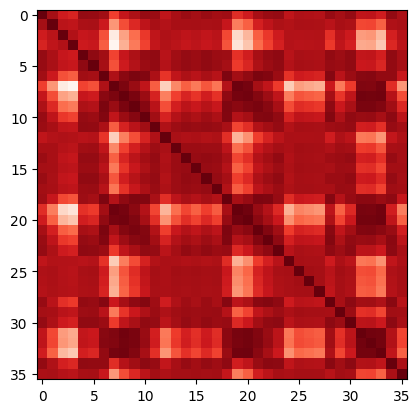

In [214]:
# rank correlation based on rates
n = len(rates.columns)
correlations = spearman_rank_correlation_matrix(rates)
cdf = pd.DataFrame(index=rates.columns, data=correlations, columns=rates.columns)
plt.imshow(cdf, cmap="Reds")
cdf

Month                          2022-07  2022-08  2022-09  2022-10  2022-11  \
spatial_unit                                                                 
(9755805559, 26299410, 0)         25.0      8.0      7.0      6.0      2.0   
(12088322948, 1207014146, 0)       7.0      8.0    156.0    129.0    265.0   
(9405615106, 244449799, 0)        90.0    190.0    392.0    348.0     76.0   
(9405615106, 921265743, 0)       589.0    120.0     44.0     11.0      6.0   
(249281045, 249281075, 0)          1.0      1.0      1.0      1.0      6.0   
...                                ...      ...      ...      ...      ...   
(12840668980, 12467726967, 0)   1437.0    651.0    714.0    670.0   1204.0   
(12843840683, 1336722281, 0)    1437.0   5688.0   5089.0   4741.0   4144.0   
(12848422868, 27415046, 0)      5286.0   5688.0   5089.0   4741.0   4144.0   
(12889120735, 983507402, 0)     1437.0   1621.0   5089.0   4741.0   4144.0   
(318837, 270591425, 0)          5286.0    341.0    392.0    348.0   4144.0   

Month                          2022-12  2023-01  2023-02  2023-03  2023-04  \
spatial_unit                                                                 
(9755805559, 26299410, 0)          1.0      1.0      7.0      3.0     15.0   
(12088322948, 1207014146, 0)     113.0    308.0     60.0     31.0     10.0   
(9405615106, 244449799, 0)        55.0     28.0     33.0     22.0     51.0   
(9405615106, 921265743, 0)         8.0      6.0      1.0      2.0      3.0   
(249281045, 249281075, 0)         15.0     14.0     19.0     31.0      8.0   
...                                ...      ...      ...      ...      ...   
(12840668980, 12467726967, 0)    934.0   3019.0    711.0    912.0   1108.0   
(12843840683, 1336722281, 0)    3549.0   3019.0   2926.0   3393.0   3919.0   
(12848422868, 27415046, 0)      3549.0   3019.0   2926.0   3393.0   3919.0   
(12889120735, 983507402, 0)     3549.0   3019.0   2926.0   3393.0   3919.0   
(318837, 270591425, 0)          3549.0   3019.0   2926.0   3393.0   3919.0   

Month                          ...  2024-07  2024-08  2024-09  2024-10  \
spatial_unit                   ...                                       
(9755805559, 26299410, 0)      ...      3.0      5.0      5.0      8.0   
(12088322948, 1207014146, 0)   ...    251.0   1550.0   1422.0    177.0   
(9405615106, 244449799, 0)     ...     51.0     56.0    120.0    177.0   
(9405615106, 921265743, 0)     ...      6.0      7.0     11.0     17.0   
(249281045, 249281075, 0)      ...      1.0      1.0      1.0      1.0   
...                            ...      ...      ...      ...      ...   
(12840668980, 12467726967, 0)  ...   5053.0   4996.0   4710.0   4641.0   
(12843840683, 1336722281, 0)   ...   5053.0   4996.0   4710.0   4641.0   
(12848422868, 27415046, 0)     ...   1567.0   4996.0   4710.0   4641.0   
(12889120735, 983507402, 0)    ...   5053.0   4996.0   4710.0   4641.0   
(318837, 270591425, 0)         ...   5053.0   4996.0   4710.0    593.0   

Month                          2024-11  2024-12  2025-01  2025-02  2025-03  \
spatial_unit                                                                 
(9755805559, 26299410, 0)          1.0      3.0      4.0     13.0      7.0   
(12088322948, 1207014146, 0)       5.0      2.0      2.0      3.0      1.0   
(9405615106, 244449799, 0)       277.0    101.0    115.0     55.0     10.0   
(9405615106, 921265743, 0)        21.0      6.0      8.0      4.0     10.0   
(249281045, 249281075, 0)         10.0     17.0     12.0      7.0      4.0   
...                                ...      ...      ...      ...      ...   
(12840668980, 12467726967, 0)   4374.0   4063.0   3497.0   2968.0   3385.0   
(12843840683, 1336722281, 0)    4374.0   4063.0   3497.0   2968.0   3385.0   
(12848422868, 27415046, 0)      4374.0   1143.0    887.0    708.0   3385.0   
(12889120735, 983507402, 0)     4374.0   4063.0   3497.0   2968.0   3385.0   
(318837, 270591425, 0)           537.0    257.0    887.0    708.0   338

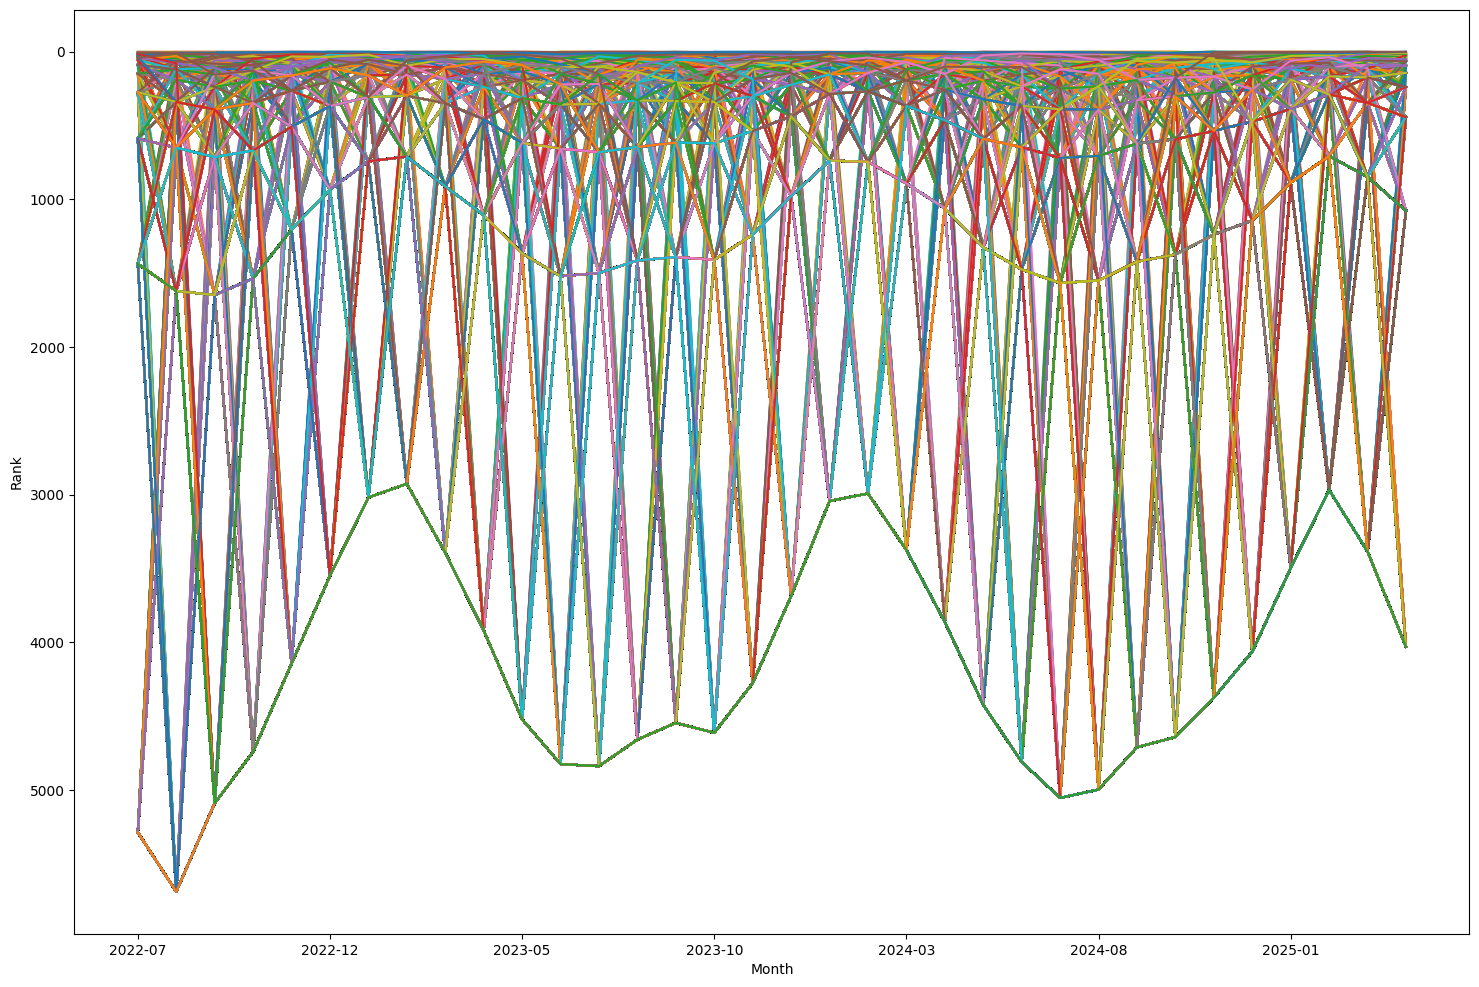

In [215]:
# ranks based on counts
count_ranks = smoothed_counts.apply(lambda col: col.rank(method="min", ascending=False))

ax = count_ranks.T.plot(figsize=(18, 12), xlabel="Month", ylabel="Rank", legend=False)
ax.invert_yaxis()

count_ranks.sort_values(by=count_ranks.columns[-1])

Month                          2022-07  2022-08  2022-09  2022-10  2022-11  \
spatial_unit                                                                 
(683271081, 1428319274, 0)      5286.0   5688.0   5089.0   4741.0   4144.0   
(358502564, 1224680698, 0)       231.0     81.0     40.0     39.0     14.0   
(12088322946, 1207014159, 0)      30.0     40.0     47.0    137.0    112.0   
(5728654616, 1640611836, 0)       20.0     25.0     31.0    102.0     79.0   
(1740394904, 243857756, 0)      5286.0   5688.0   5089.0   4741.0   4144.0   
...                                ...      ...      ...      ...      ...   
(12840668980, 12467726967, 0)   1145.0    417.0    462.0    401.0    969.0   
(12843840683, 1336722281, 0)    1036.0   5688.0   5089.0   4741.0   4144.0   
(12848422868, 27415046, 0)      5286.0   5688.0   5089.0   4741.0   4144.0   
(12889120735, 983507402, 0)     4563.0   4923.0   5089.0   4741.0   4144.0   
(318837, 270591425, 0)          5286.0   5644.0   5047.0   4703.0   4144.0   

Month                          2022-12  2023-01  2023-02  2023-03  2023-04  \
spatial_unit                                                                 
(683271081, 1428319274, 0)      3549.0   3019.0   2926.0   3393.0   3919.0   
(358502564, 1224680698, 0)        21.0      3.0      2.0      3.0      5.0   
(12088322946, 1207014159, 0)    3549.0   3019.0   2926.0   3393.0    113.0   
(5728654616, 1640611836, 0)       65.0   3019.0     56.0     62.0     83.0   
(1740394904, 243857756, 0)      3549.0   3019.0   2926.0   3393.0   3919.0   
...                                ...      ...      ...      ...      ...   
(12840668980, 12467726967, 0)    784.0   3019.0    604.0    742.0    862.0   
(12843840683, 1336722281, 0)    3549.0   3019.0   2926.0   3393.0   3919.0   
(12848422868, 27415046, 0)      3549.0   3019.0   2926.0   3393.0   3919.0   
(12889120735, 983507402, 0)     3549.0   3019.0   2926.0   3393.0   3919.0   
(318837, 270591425, 0)          3549.0   3019.0   2926.0   3393.0   3919.0   

Month                          ...  2024-07  2024-08  2024-09  2024-10  \
spatial_unit                   ...                                       
(683271081, 1428319274, 0)     ...      2.0      2.0      1.0   4641.0   
(358502564, 1224680698, 0)     ...      1.0      1.0      2.0      3.0   
(12088322946, 1207014159, 0)   ...   5053.0   4996.0   4710.0    118.0   
(5728654616, 1640611836, 0)    ...   5053.0   4996.0   4710.0     88.0   
(1740394904, 243857756, 0)     ...      7.0      7.0      7.0     16.0   
...                            ...      ...      ...      ...      ...   
(12840668980, 12467726967, 0)  ...   5053.0   4996.0   4710.0   4641.0   
(12843840683, 1336722281, 0)   ...   5053.0   4996.0   4710.0   4641.0   
(12848422868, 27415046, 0)     ...   4776.0   4996.0   4710.0   4641.0   
(12889120735, 983507402, 0)    ...   5053.0   4996.0   4710.0   4641.0   
(318837, 270591425, 0)         ...   5053.0   4996.0   4710.0   4625.0   

Month                          2024-11  2024-12  2025-01  2025-02  2025-03  \
spatial_unit                                                                 
(683271081, 1428319274, 0)      4374.0   4063.0      3.0      1.0      1.0   
(358502564, 1224680698, 0)         3.0      2.0      1.0      2.0      2.0   
(12088322946, 1207014159, 0)     109.0     14.0     23.0     20.0      4.0   
(5728654616, 1640611836, 0)       79.0     67.0   3497.0   2968.0   3385.0   
(1740394904, 243857756, 0)         9.0     13.0      8.0      9.0      6.0   
...                                ...      ...      ...      ...      ...   
(12840668980, 12467726967, 0)   4374.0   4063.0   3497.0   2968.0   3385.0   
(12843840683, 1336722281, 0)    4374.0   4063.0   3497.0   2968.0   3385.0   
(12848422868, 27415046, 0)      4374.0   3851.0   3286.0   2795.0   3385.0   
(12889120735, 983507402, 0)     4374.0   4063.0   3497.0   2968.0   3385.0   
(318837, 270591425, 0)          4360.0   4027.0   3491.0   2965.0   338

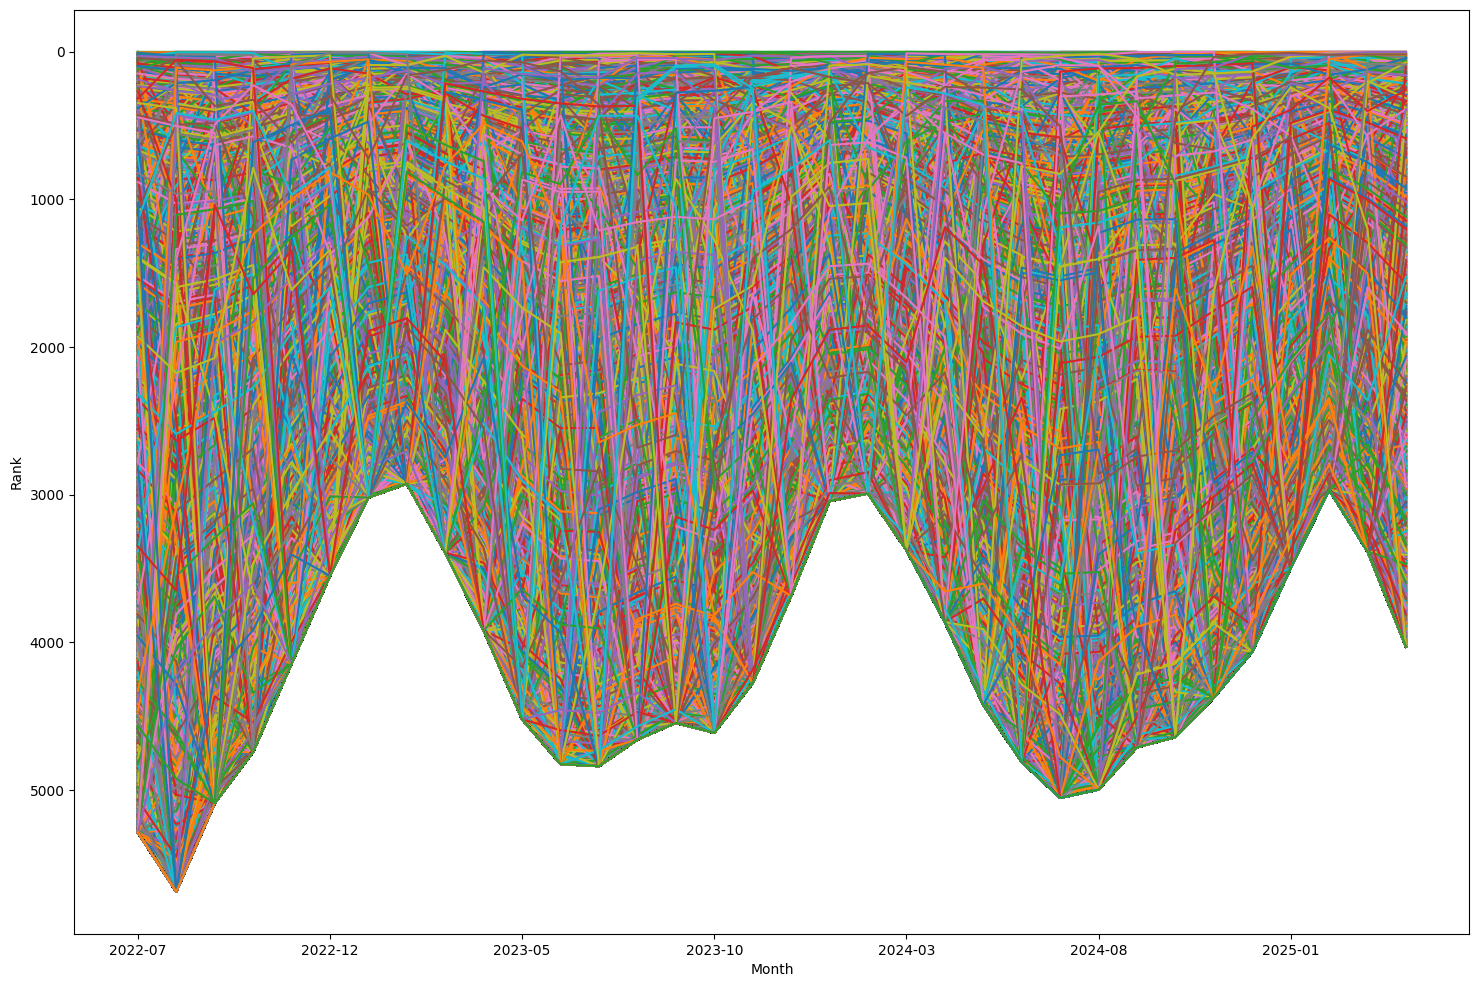

In [216]:
# ranks based on rates
rate_ranks = smoothed_rates.apply(lambda col: col.rank(method="min", ascending=False))

ax = rate_ranks.T.plot(figsize=(18, 12), xlabel="Month", ylabel="Rank", legend=False)
ax.invert_yaxis()

rate_ranks.sort_values(by=rate_ranks.columns[-1])

In [238]:
spearman_rank_correlation(count_ranks.iloc[:, 0], count_ranks.iloc[:, 0])

np.float64(1.0)

In [234]:
month_on_month = pd.DataFrame(index=pd.MultiIndex.from_tuples(pairwise(count_ranks.columns)))

# month_on_month["Spearman rank correlation (count)"] = month_on_month.index.map(
#     lambda idx: spearman_rank_correlation(count_ranks[idx[0]], count_ranks[idx[1]])
# )
# month_on_month["Spearman rank correlation (rate)"] = month_on_month.index.map(
#     lambda idx: spearman_rank_correlation(rate_ranks[idx[0]], count_ranks[idx[1]])
# )
month_on_month["Rank-biased overlap (count)"] = month_on_month.index.map(
    lambda idx: rank_biased_overlap(count_ranks[idx[0]], count_ranks[idx[1]])
)
month_on_month["Rank-biased overlap (rate)"] = month_on_month.index.map(
    lambda idx: rank_biased_overlap(rate_ranks[idx[0]], rate_ranks[idx[1]])
)
month_on_month["Cosine similarity (count)"] = month_on_month.index.map(
    lambda idx: cosine_similarity(smoothed_counts[idx[0]], smoothed_counts[idx[1]])
)
month_on_month["Cosine similarity (rate)"] = month_on_month.index.map(
    lambda idx: cosine_similarity(smoothed_rates[idx[0]], smoothed_rates[idx[1]])
)

month_on_month

KeyboardInterrupt: 

In [232]:
def calc_stats(counts: pd.Series):
    total_areas = len(counts)
    full_lorenz = lorenz_curve(counts)
    gini, lorenz = calc_gini(counts)  # .sort_values().cumsum() / counts.sum()
    return pd.Series(
        data={
            "prop_zero": (counts == 0).mean(),
            "prop_threshold": (full_lorenz >= SAMPLE_FRACTION).sum() / total_areas,
            "gini": gini,
            "lorenz": lorenz.to_numpy(),
            # TODO list top x areas?
        },
        name=counts.name,
    )


stats = pd.concat([calc_stats(series) for _, series in smoothed_rates.items()], axis=1).T
stats

prop_zero prop_threshold      gini  \
2022-07  0.736711       0.041249  0.869676   
2022-08  0.716684       0.042096  0.863672   
2022-09  0.746525       0.034624  0.882148   
2022-10  0.763862       0.033577  0.888787   
2022-11  0.793603       0.030289  0.900337   
2022-12  0.823245       0.026952  0.912762   
2023-01  0.849649       0.022568  0.925896   
2023-02  0.854282       0.021272  0.929039   
2023-03  0.831017       0.024261  0.919032   
2023-04  0.804812       0.025905  0.909302   
2023-05  0.774822       0.027699  0.899354   
2023-06  0.759727       0.028347  0.894668   
2023-07   0.75903       0.027151  0.895633   
2023-08  0.767997       0.027699  0.896955   
2023-09  0.773626       0.027001  0.899293   
2023-10  0.770288       0.029642   0.89473   
2023-11  0.787027       0.026553   0.90328   
2023-12   0.81642       0.024212  0.914405   
2024-01  0.848453       0.020575  0.927893   
2024-02  0.850994       0.020176  0.929165   
2024-03  0.831914       0.021771  0.922047   
2024-04  0.807652       0.024461  0.911784   
2024-05  0.779654       0.028496  0.899643   
2024-06  0.760474       0.031784  0.889874   
2024-07  0.748319       0.031087  0.887443   
2024-08  0.751158       0.031834  0.886583   
2024-09  0.765406       0.030289  0.892415   
2024-10  0.768844       0.031933  0.891229   
2024-11  0.782145       0.029144  0.898953   
2024-12  0.797639        0.02745  0.905183   
2025-01  0.825836       0.024062  0.917736   
2025-02   0.85219       0.019927  0.930164   
2025-03  0.831415       0.022269  0.921616   
2025-04  0.799283       0.027898  0.905644   

                                                    lorenz  
2022-07  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-08  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-09  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-12  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-02  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-03  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-04  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-05  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-06  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-07  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-08  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-09  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-12  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-02  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-03  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-04  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-05  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-06  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-07  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-08  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-09  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-12  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2025-01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2025-02  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2025-03  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2025-04  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

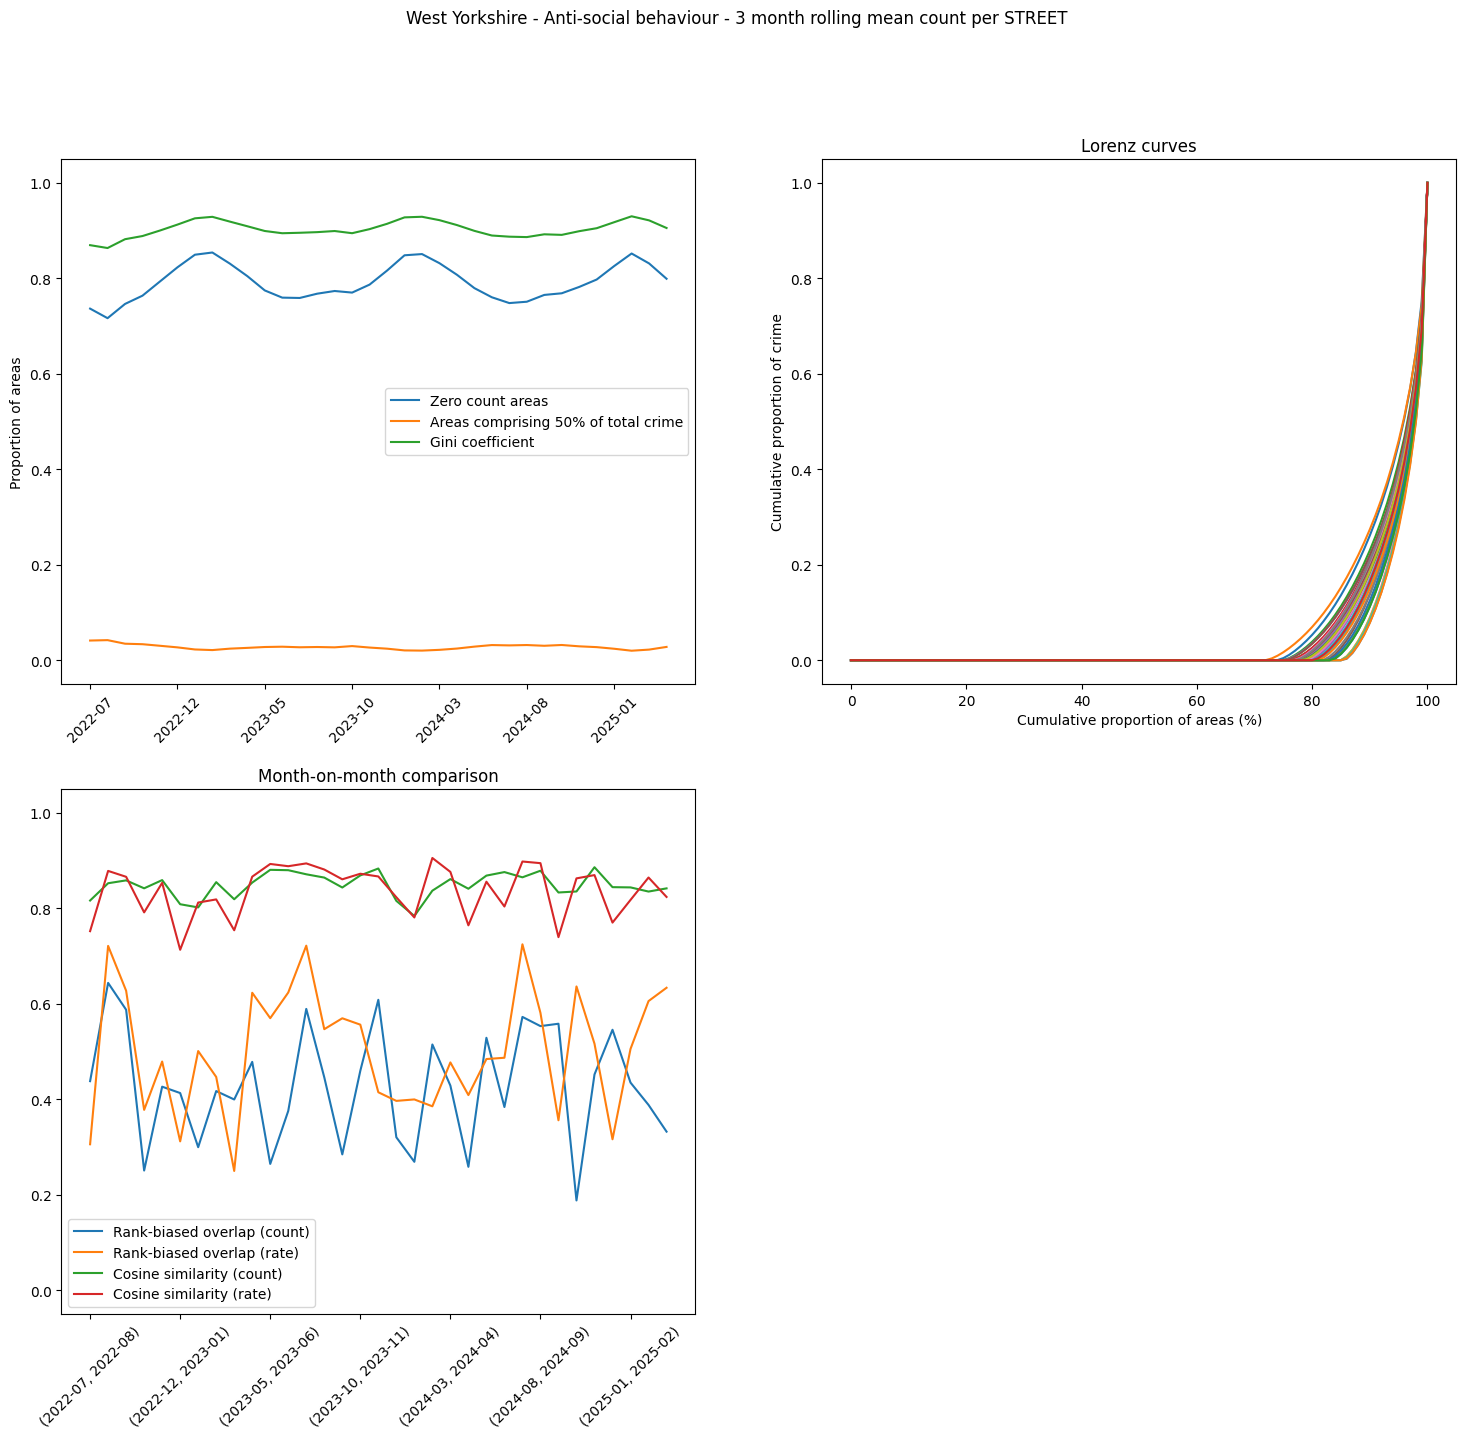

In [233]:
fig, axs = plt.subplots(2, 2, figsize=(18, 15))
fig.suptitle(f"{FORCE} - {CATEGORY} - {OBSERVATION_WINDOW} month rolling mean count per {AREA}")
# plt.tight_layout()
stats.prop_zero.plot(ax=axs[0, 0], label="Zero count areas")
stats.prop_threshold.plot(ax=axs[0, 0], label=f"Areas comprising {SAMPLE_FRACTION:.0%} of total crime")
stats.gini.plot(ax=axs[0, 0], label="Gini coefficient")
axs[0, 0].tick_params(axis="x", rotation=45)
axs[0, 0].set_ylabel("Proportion of areas")
axs[0, 0].set_ylim((-0.05, 1.05))
axs[0, 0].legend()

for name, row in stats.iterrows():
    axs[0, 1].plot(range(101), row["lorenz"], label=f"{name}")
axs[0, 1].set_xlabel("Cumulative proportion of areas (%)")
axs[0, 1].set_ylabel("Cumulative proportion of crime")
axs[0, 1].set_title("Lorenz curves")

month_on_month.plot(ax=axs[1, 0])
axs[1, 0].set_title("Month-on-month comparison")
axs[1, 0].tick_params(axis="x", rotation=45)
axs[1, 0].set_ylim((-0.05, 1.05))

if AREA != "STREET":
    spatial_units.join(rates.sum(axis=1).rename("density")).fillna(0).plot(
        ax=axs[1, 1], column="density", alpha=1, legend=True
    )
axs[1, 1].set_axis_off()